In [290]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [291]:

import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [292]:
from preprocessing.smoothing import clean_using_pca

In [293]:

data_folder='E://HeadRestrainedDataset//all_csv//'
protocol_name='all_csv'
path='E://HeadRestrainedDataset//all_csv//'

filelist=[]
for file in os.listdir(path):
    if file.endswith(".csv"):
        filelist.append(os.path.join(path, file))


In [294]:
#filelist = ['2021-10-07-nefma-7dpf-f1-all_logs']

Tensor = np.zeros((3500,10,0))
stop = False
#df = pd.read_csv('E://HeadRestrainedDataset//all_csv//'+filelist[0]+'.csv')
df = pd.read_csv(filelist[0])

NumSegment = 16

relative_tail_angle = df[['angle'+str(i) for i in range(NumSegment)]]
relative_tail_angle = relative_tail_angle.values
T = np.max(relative_tail_angle.shape)

cumul_tail_angle=np.cumsum(relative_tail_angle,1)

tail_angle = resize(cumul_tail_angle, (cumul_tail_angle.shape[0], 10),order=0) # 0 for nearest neighbor


# Use PCA for Cleaning (Could use DMD for better results)
tail_angle = clean_using_pca(tail_angle,num_pcs=4)

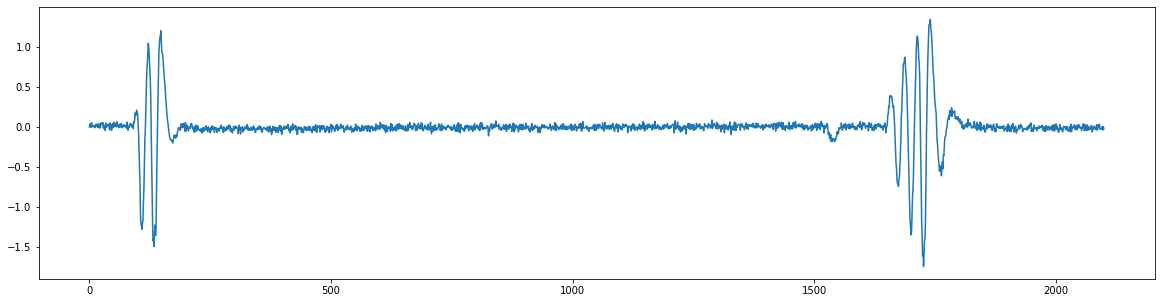

In [299]:
# Diagnostic Plot:
Duration = 700*3
IdSt = np.random.randint(T-Duration)
fig, (ax) = plt.subplots(1,1,figsize=(20,5), sharex=True)

ax.plot(tail_angle[IdSt:IdSt+Duration,7])

plt.show()


In [300]:
from preprocessing.baseline import remove_slow_trend

In [301]:
tail_angle_detrend = remove_slow_trend(tail_angle,ref_segment=7)
#TODO: Improve Detrending using speed (robust diff gives very good smoothing using filter~21 and could be used to remove slow trend)

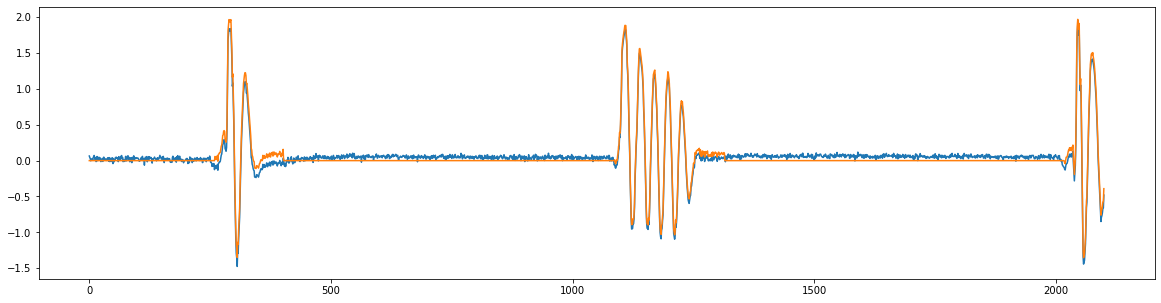

In [306]:
# Diagnostic Plot:
Duration = 700*3
IdSt = np.random.randint(T-Duration)
fig, (ax) = plt.subplots(1,1,figsize=(20,5), sharex=True)

ax.plot(tail_angle[IdSt:IdSt+Duration,7])
ax.plot(tail_angle_detrend[IdSt:IdSt+Duration,7])

plt.show()

(150, 7, 10)


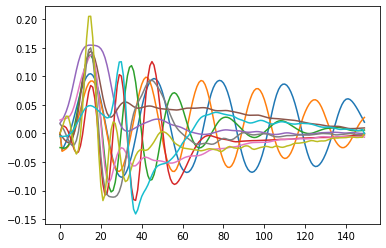

In [307]:
f = np.load('./sparse_coding/Dict_OptimizedHeadRestrained.npz')
Dict = f['Dict']
N_atoms = Dict.shape[2]
Wg = np.ones((1,N_atoms))
print(Dict.shape)

plt.plot(Dict[:,-1,:])
plt.show()

In [308]:
from sparse_coding.sparse_coding import compute_sparse_code

In [309]:
z,tail_angle_hat = compute_sparse_code(tail_angle_detrend[:,:7],Dict,Wg,lmbda=0.01,gamma=0.05,mu=0.05,Whn=60)

Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------
   0  4.33e+03  1.58e+03  1.86e+04  4.50e+04  6.26e+03  4.24e-01  1.18e+01  1.50e+00
   1  8.28e+03  1.26e+03  2.25e+04  1.19e+05  1.69e+04  8.05e-01  1.72e+00  1.50e+00
   2  1.00e+04  1.92e+03  2.09e+04  1.38e+05  1.94e+04  7.67e-01  1.80e-01  9.99e-01
   3  9.10e+03  2.05e+03  1.43e+04  1.20e+05  1.81e+04  4.75e-01  2.85e-01  2.01e+00
   4  8.67e+03  2.26e+03  1.21e+04  1.06e+05  1.99e+04  2.03e-01  2.80e-01  2.52e+00
   5  9.50e+03  2.21e+03  1.28e+04  1.18e+05  2.54e+04  1.70e-01  1.71e-01  2.09e+00
   6  9.23e+03  2.24e+03  1.19e+04  1.11e+05  2.65e+04  1.55e-01  1.35e-01  2.09e+00
   7  8.93e+03  2.31e+03  1.08e+04  1.04e+05  2.62e+04  1.40e-01  9.93e-02  2.09e+00
   8  8.71e+03  2.40e+03  9.95e+03  9.75e+04  2.67e+04  1.01e-01  8.32e-02  2.41e+00
   9  8.66e+03  2.43e+03  9.56e+03  9.44e+04  2.83e+04  7.66e-02 

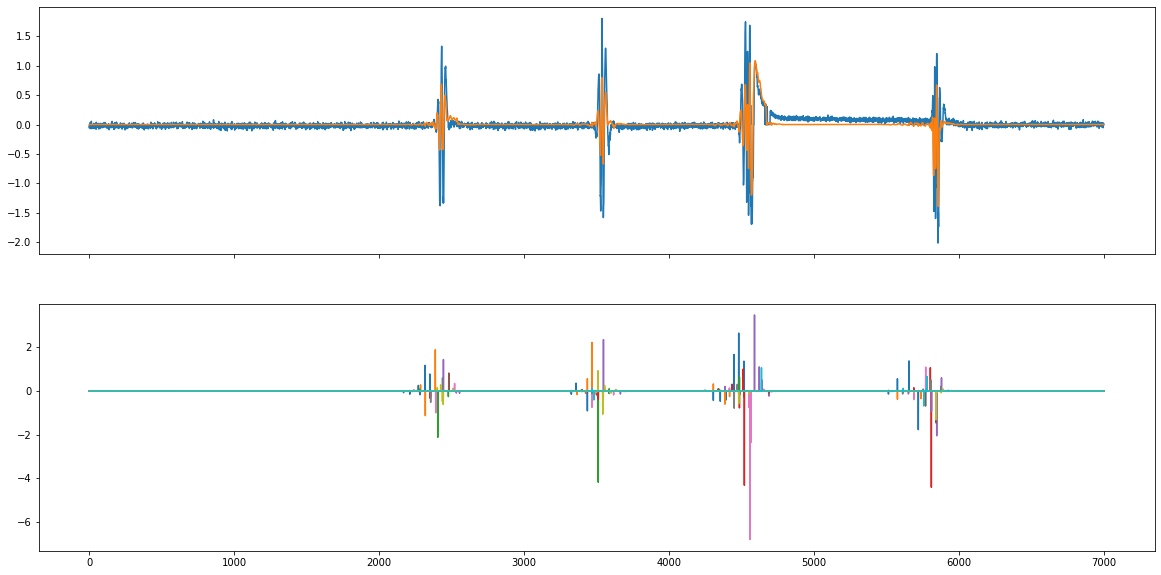

In [347]:
# Diagnostic Plot:
Duration = 700*10
IdSt = np.random.randint(T-Duration)
fig, (ax) = plt.subplots(2,1,figsize=(20,10), sharex=True)
ax[0].plot(tail_angle[IdSt:IdSt+Duration,7])
ax[0].plot(tail_angle_hat[IdSt:IdSt+Duration,-1])
ax[1].plot(z[IdSt:IdSt+Duration,:])
plt.show()

# Segmentation

In [311]:
from scipy.signal import find_peaks
z_normalized = np.copy(z)
#for i in range(z.shape[1]):
#    z_normalized[:,i] = z[:,i]/np.std(z[:,i])

z_max = np.max(np.abs(z_normalized),axis=1)
peaks, _ = find_peaks(z_max, height=1,distance=120)
peaks_bin = np.zeros(T)
peaks_bin[peaks]=1

## For each peak find next peak or gap in peaks...
Bout_Duration = 120
kernel = np.ones(Bout_Duration)
filtered_forward = np.convolve(kernel,peaks_bin, mode='full')[:peaks_bin.shape[0]]
is_tail_active = 1.0*(filtered_forward>0)#*(filtered_backward>0)

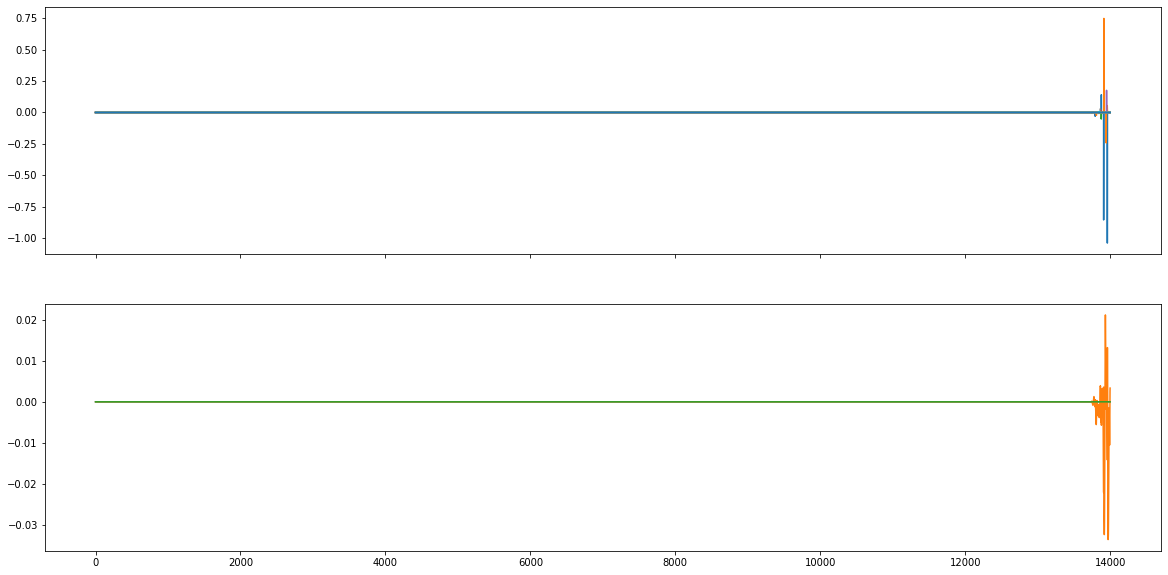

In [312]:
# Diagnostic Plot:
Duration = 700*20
IdSt = np.random.randint(T-Duration)
fig, (ax) = plt.subplots(2,1,figsize=(20,10), sharex=True)

ax[0].plot(z[IdSt:IdSt+Duration,:])
ax[0].plot(is_tail_active[IdSt:IdSt+Duration])

ax[1].plot(tail_angle_detrend[IdSt:IdSt+Duration,7])
ax[1].plot(tail_angle_hat[IdSt:IdSt+Duration,-1])

ax[1].plot(is_tail_active[IdSt:IdSt+Duration])

plt.show()

In [313]:
from segmentation.align import align_bout_peaks


In [314]:
bouts_array = np.zeros((len(peaks),140,7))
bouts_hat_array = np.zeros((len(peaks),140,7))

onset_list = []
offset_list = []
aligned_peaks = []

Margin_before_peak = 0
i = 0
for iter_,peak in enumerate(peaks):
        if ((peak>Margin_before_peak)&(peak+(140-Margin_before_peak)<T)):
            id_st = peak - Margin_before_peak
            id_ed = id_st +140
            tmp = tail_angle[id_st:id_ed,7]
            try:
                peak_location = align_bout_peaks(tmp,quantile_threshold = 0.25 , minimum_peak_size = 0.25, minimum_peak_to_peak_amplitude = 4,debug_plot_axes=None)
            except:
                peak_location = np.nan
                
            if np.isnan(peak_location):
                peak_location = peak
            else:
                aligned_peaks.append(id_st+peak_location)
                id_st = id_st+peak_location - Margin_before_peak-20
                id_ed = id_st +140
            bouts_array[i,:,:] = tail_angle[id_st:id_ed,:7]
            bouts_hat_array[i,:,:] = tail_angle_hat[id_st:id_ed,:]
            i = i+1
            onset_list.append(id_st)
            offset_list.append(id_ed)
            

bouts_array = bouts_array[:i,:,:]
bouts_hat_array = bouts_hat_array[:i,:,:]

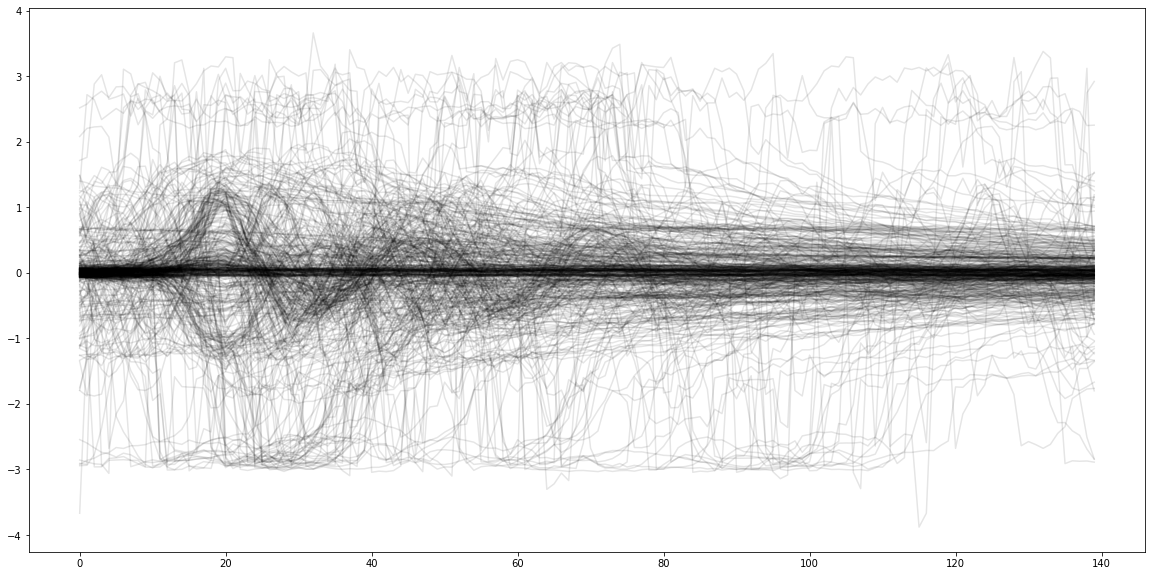

In [315]:

fig, (ax) = plt.subplots(1,1,figsize=(20,10))

for i in range(bouts_array.shape[0]):
    ax.plot(bouts_array[i,:,-1],'k',alpha=0.1)
plt.show()

In [316]:
from classification.template_bouts import generate_template_bouts

In [317]:
templates_flat,templates_labels,NameCat,Duration_after_Downsampling = generate_template_bouts(format='tail',template_duration = 140,target_fps=700,ExludeCaptureSwim=True,delays=[0])

In [318]:
templates_flat.shape

(30800, 980)

In [319]:
templates_full = np.reshape(templates_flat,(templates_flat.shape[0],7,140))
templates_full = templates_full[:,:,:60]
print(templates_full.shape)
templates_flat = np.reshape(templates_full,(templates_full.shape[0],60*7))
print(templates_flat.shape)

(30800, 7, 60)
(30800, 420)


In [320]:
bouts_array.shape

(435, 140, 7)

In [321]:
bouts_array = bouts_array[:,:60,:]
bouts_array_flat = np.reshape(np.swapaxes(bouts_array, 1, 2),(bouts_array.shape[0],bouts_array.shape[1]*bouts_array.shape[2]))
bouts_array_flat.shape

(435, 420)

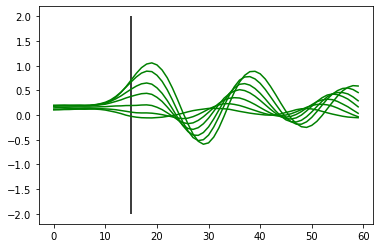

In [322]:
plt.plot(templates_full[5000,:,:].T,'g')
plt.vlines(15,-2,2,'k')

In [323]:
templates_flat.shape

(30800, 420)

In [324]:
bouts_array = bouts_array[:,:,:]
bouts_array_flat = np.reshape(np.swapaxes(bouts_array, 1, 2),(bouts_array.shape[0],bouts_array.shape[1]*bouts_array.shape[2]))
bouts_array_flat.shape

(435, 420)

In [325]:

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(templates_flat, templates_labels)

KNeighborsClassifier()

In [326]:
bout_cat = knn.predict(bouts_array_flat)

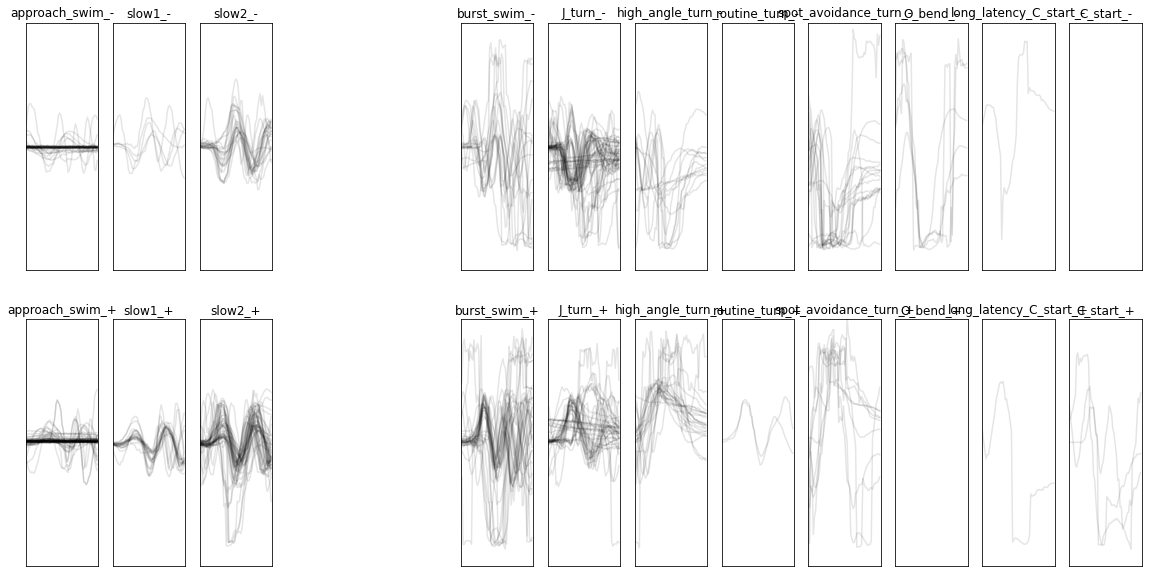

In [327]:
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((templates_labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    
    id = np.where(bout_cat==b)[0]       
    if len(id)>0:
        id = id[0:100]
        ax0.plot(bouts_array_flat[id,60*6:].T,'k',alpha=.1)

    ax0.set_xlim(0,60)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


In [328]:
bout_cat.shape

(435,)

In [329]:
np.unique(templates_labels)

array([ 0.,  1.,  2.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 18., 19., 20., 21., 22., 23., 24., 25.])

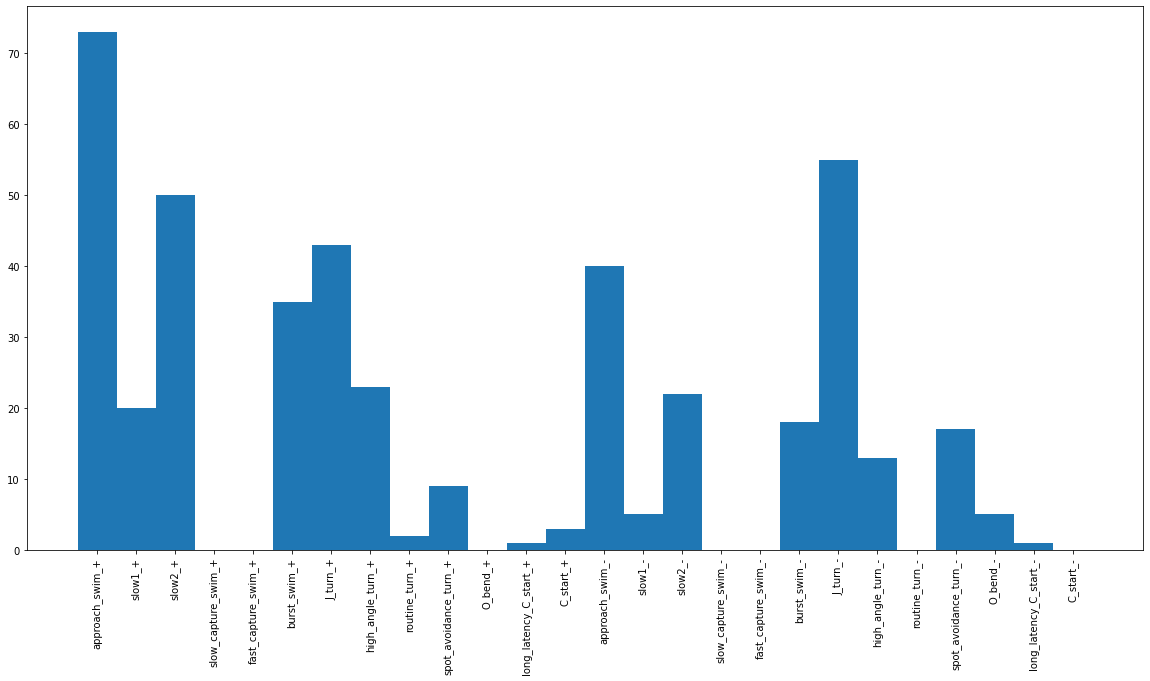

In [330]:
fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

plt.hist(bout_cat,np.linspace(-0.5,25.5,27))
plt.xticks(np.arange(26),NameCat, rotation='vertical')
plt.show()

In [331]:
Max_ampl = np.max(np.abs(bouts_array),axis=(1,2))

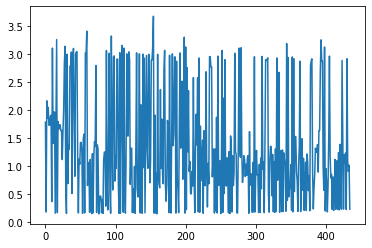

In [332]:
plt.plot(Max_ampl)

spot_avoidance_turn_-


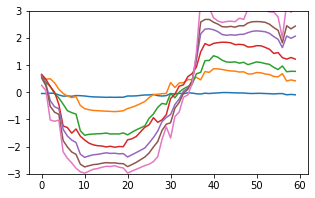

In [345]:
large = False
while large==False:
    i = np.random.randint(bouts_array.shape[0])
    if np.max(np.abs(bouts_array[i,:,:]))>3:
        large=True

print(NameCat[int(bout_cat[i])])
plt.figure(figsize=(5,3))
plt.plot(bouts_array[i,:,:])
plt.ylim(-3,3)
plt.show()

## Detect Outlier

### Compute within category variance

### How is variance differing

## Detect Burst Swim

In [8]:
from utils.utils import robust_diff

In [9]:
tail_speed = np.zeros_like(tail_angle)
for s in range(tail_angle.shape[1]):
    tail_speed[:,s]= robust_diff(tail_angle[:,s],dt=1/700, filter_length=71)

In [10]:
tail_speed[np.isnan(tail_speed)]=0

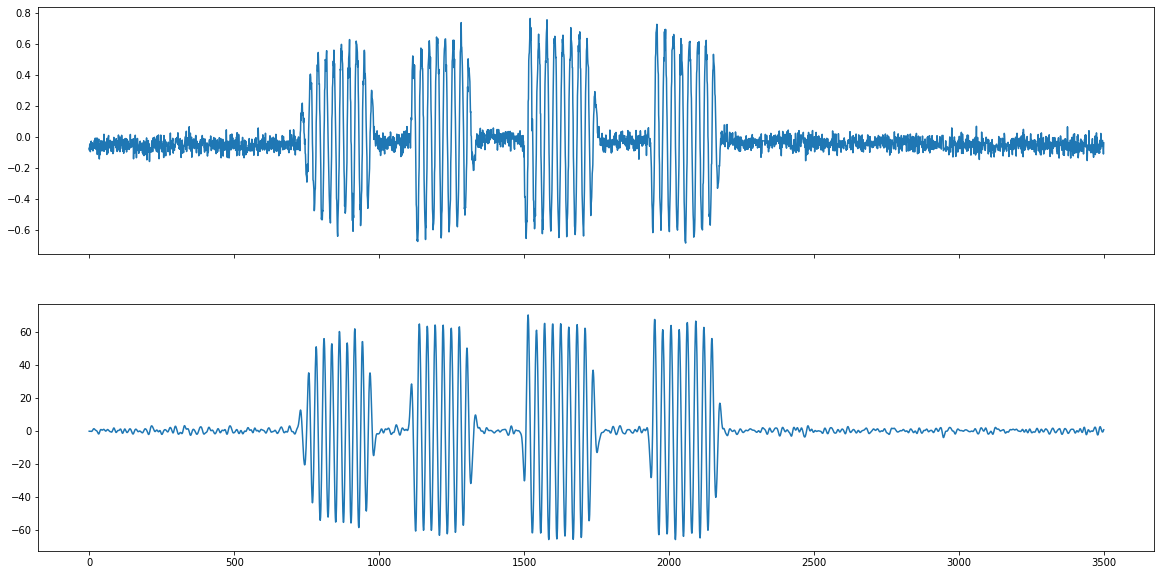

In [48]:
# Diagnostic Plot:
Duration = 700*5
IdSt = np.random.randint(T-Duration)
fig, (ax) = plt.subplots(2,1,figsize=(20,10), sharex=True)

ax[0].plot(tail_angle[IdSt:IdSt+Duration,7])
ax[1].plot(tail_speed[IdSt:IdSt+Duration,7])

plt.show()

In [54]:
f = np.load('./sparse_coding/Dict_OptimizedHeadRestrained.npz')
Dict = f['Dict']


In [55]:
Dict.shape

(150, 7, 10)

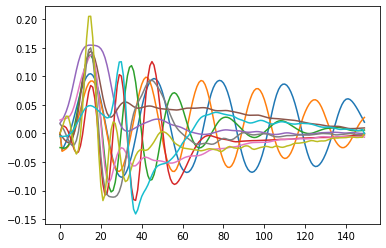

In [56]:
plt.plot(Dict[:,-1,:])


In [ ]:
Dict = np.load('fullDataset19atomsTu.npy')

id_forward = np.array([4, 12, 13, 14, 15, 17, 18])
id_fast = np.array([2, 5, 10])
id_turn = np.array([0, 1, 3, 8, 9, 16])
id_escape = np.array([6, 7, 11])


N_atoms = Dict.shape[2]

# First Option full mutual inhibition:
Wg = np.ones((1,N_atoms))

# Alternative Option inhibition between groups:
'''
Wg = np.ones((4,19))
for i,list_ in enumerate([id_forward,id_fast,id_turn,id_escape]):
    for k in list_:
        Wg[i,k]=0'''


In [4]:
filelist = ['2021-10-07-nefma-7dpf-f1-all_logs']

Tensor = np.zeros((3500,10,0))
stop = False
df = pd.read_csv('E://HeadRestrainedDataset//all_csv//'+filelist[0]+'.csv')

NumSegment = 16

tail_angle = df[['angle'+str(i) for i in range(NumSegment)]]
tail_angle = tail_angle.values
#tail_angle = np.cumsum(tail_angle,axis=1)
print(tail_angle.shape)
tail_angle = tail_angle[:,1:]
print(tail_angle.shape)

tail_angle = resize(tail_angle, (tail_angle.shape[0], 10),order=0) # 0 for nearest neighbor
tail = Tail(tail_angle)
tail.tail_angle_preprocessing()

tail_angle = tail.angle_smooth
tail_angle_detrend = np.zeros_like(tail_angle) 

ref_segment = 7
x = np.copy(tail_angle[:,ref_segment])
# Compute tail active
trend = signal.savgol_filter(x, window_length=31, polyorder=1, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
detrend = np.abs(x-trend)
x = pd.DataFrame({'x':detrend})
win = 15
x = x.rolling(win).mean().values[:,0]
BT,ax = estimate_threshold_using_GMM(x,margin_std=2.5,axis=None)

baseline = np.zeros_like(x)
tail_active = (x>BT)

kernel = np.ones(40)
filtered_timeforward = np.convolve(kernel,tail_active, mode='full')[:tail_active.shape[0]] # Trick to make convolution causal
tail_active = 1.0*((filtered_timeforward)>0)#*filtered_timebackward)>0)

# Remove too short activation:
onset,offset,duration = find_onset_offset_numpy(tail_active)
tail_active = 0*tail_active
for on_,off_,dur_ in zip(onset,offset,duration):
    if dur_>60:
        tail_active[on_:off_]=1

tail_angle_detrend = np.zeros_like(tail_angle)
for s in range(tail_angle.shape[1]):

    baseline = np.zeros_like(tail_active)
    baseline[tail_active==0]=tail_angle[tail_active==0,s]
    onset,offset,duration = find_onset_offset_numpy(tail_active)
    for on_,off_,dur_ in zip(onset,offset,duration):
        tmp = tail_angle[on_:off_,s]
        if dur_>1:
            baseline[on_:off_] = tmp[0]#np.linspace(tmp[0],tmp[-1],dur_)
        else:
            baseline[on_] = tail_angle[on_,s]
    tail_angle_detrend[:,s] = tail_angle[:,s]-baseline



(1266204, 16)
(1266204, 15)


# Using Free Swimming Optimized Dictionnary

In [6]:
Dict = np.load('fullDataset19atomsTu.npy')

id_forward = np.array([4, 12, 13, 14, 15, 17, 18])
id_fast = np.array([2, 5, 10])
id_turn = np.array([0, 1, 3, 8, 9, 16])
id_escape = np.array([6, 7, 11])


N_atoms = Dict.shape[2]

# First Option full mutual inhibition:
Wg = np.ones((1,N_atoms))

# Alternative Option inhibition between groups:
'''
Wg = np.ones((4,19))
for i,list_ in enumerate([id_forward,id_fast,id_turn,id_escape]):
    for k in list_:
        Wg[i,k]=0'''


'\nWg = np.ones((4,19))\nfor i,list_ in enumerate([id_forward,id_fast,id_turn,id_escape]):\n    for k in list_:\n        Wg[i,k]=0'

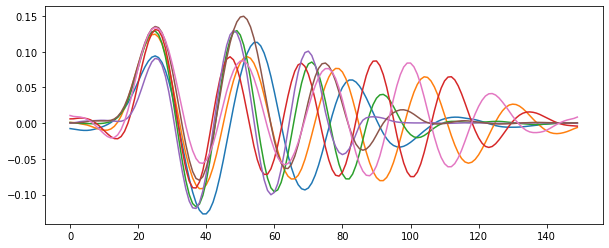

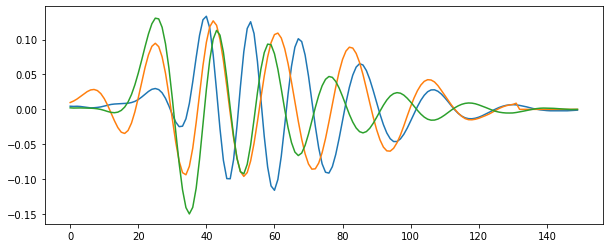

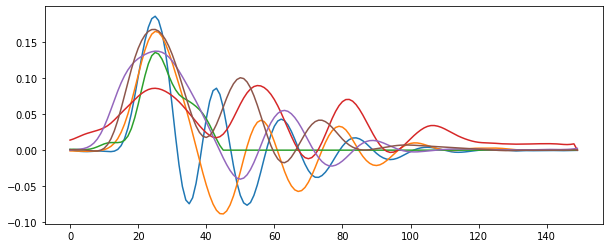

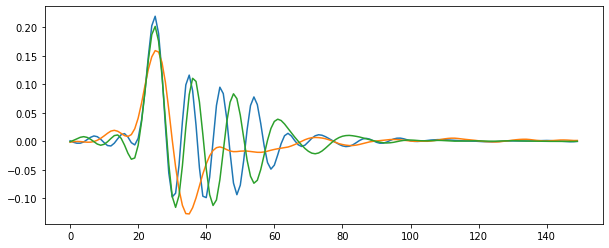

In [7]:
for list_ in [id_forward,id_fast,id_turn,id_escape]:
    plt.figure(figsize=(10,4))
    for i in list_:
        plt.plot(Dict[:,-1,i])


In [8]:
# Batch Dataset:
tail_angle_batch = batch_tail_angle(tail_angle_detrend[:,:7])

print(tail_angle_batch.shape)

T_trial = tail_angle_batch.shape[0]
N_Seg = tail_angle_batch.shape[1]
z = np.zeros((T_trial,N_atoms,1))

opt = cbpdnin.ConvBPDNInhib.Options({'Verbose': True, 'MaxMainIter': 200,
                                        'RelStopTol': 5e-3, 'AuxVarObj': False,'HighMemSolve': True})                                    
b = cbpdnin.ConvBPDNInhib(Dict[:,:,:],tail_angle_batch,lmbda =0.05, Wg=Wg,gamma=0.1,mu=0.5,Whn=60,win_args='box', opt=opt, dimK=1, dimN=1)
z = b.solve().squeeze()
tail_hat = b.reconstruct().squeeze()

# Unbatch Result
z_flat = np.zeros((z.shape[0]*z.shape[1],z.shape[2]))
for i in range(z.shape[2]):
    z_flat[:,i] = z[:,:,i].T.flatten()
z = np.copy(z_flat)
z = z[:tail_angle_detrend.shape[0],:]
tail_angle_hat_ = np.zeros((tail_hat.shape[0]*tail_hat.shape[2],tail_hat.shape[1]))
for i in range(tail_hat.shape[1]):
    tail_angle_hat_[:,i] = tail_hat[:,i,:].T.flatten()
tail_angle_hat_ = tail_angle_hat_[:tail_angle_detrend.shape[0],:]



(21000, 7, 61)
Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------
   0  1.59e+04  7.56e+02  1.43e+04  2.84e+04  2.06e+03  3.83e-01  2.82e+00  3.50e+00
   1  3.20e+04  6.22e+02  1.45e+04  6.04e+04  4.88e+03  1.00e+00  1.02e+00  3.50e+00
   2  5.27e+04  1.31e+03  1.82e+04  9.98e+04  6.24e+03  1.00e+00  1.77e-03  2.91e+00
   3  2.70e+04  5.09e+03  6.62e+03  4.26e+04  2.79e+03  8.94e-01  1.57e-01  5.81e+01
   4  1.95e+04  1.19e+04  2.59e+03  1.47e+04  1.10e+03  4.04e-01  2.89e-01  1.16e+02
   5  1.85e+04  1.22e+04  2.32e+03  1.23e+04  1.22e+03  2.05e-01  2.95e-01  1.16e+02
   6  1.78e+04  1.03e+04  2.85e+03  1.44e+04  1.65e+03  1.57e-01  2.15e-01  8.13e+01
   7  1.77e+04  8.86e+03  3.42e+03  1.69e+04  2.10e+03  1.37e-01  1.71e-01  5.83e+01
   8  1.74e+04  7.84e+03  3.74e+03  1.82e+04  2.57e+03  1.19e-01  1.36e-01  4.38e+01
   9  1.70e+04  7.08e+03  3.91e+03  1.88e+04  3.02

In [9]:
decomposition = np.zeros((z.shape[0],4))
for i,list_ in enumerate([id_forward,id_fast,id_turn,id_escape]):
    tmp = np.zeros(z.shape[0])
    for k in list_:
        decomposition[:,i] = decomposition[:,i]+np.convolve(z[:,k],Dict[:,-1,k],'full')[:z.shape[0]]


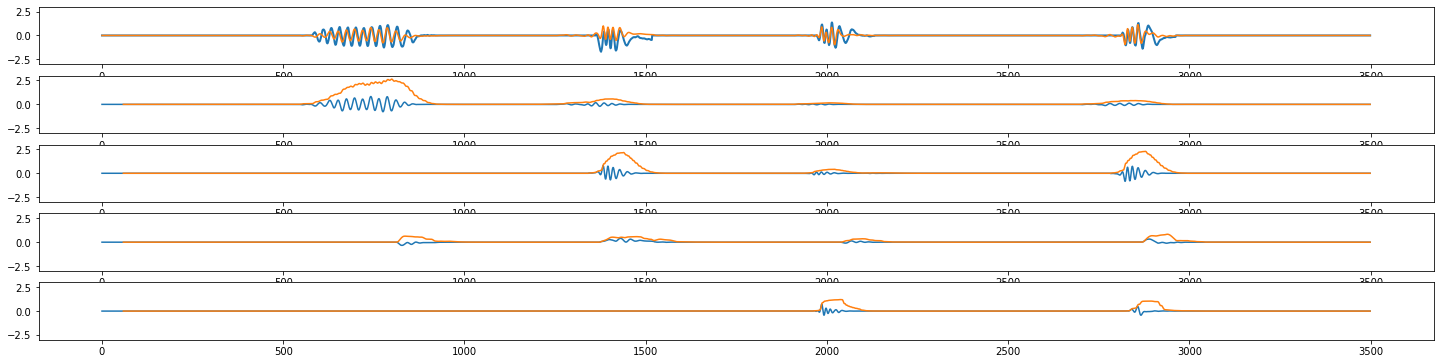

In [10]:
import matplotlib.gridspec as gridspec

Duration = 700*5
IdSt = 943000#np.random.randint(decomposition.shape[0]-Duration)


fig, ax = plt.subplots(facecolor='white',figsize=(25,15)) 

G = gridspec.GridSpec(12,1)

ax = plt.subplot(G[0])
ax.plot(tail_angle_detrend[IdSt:IdSt+Duration,-1],lw=2)
ax.plot(tail_angle_hat_[IdSt:IdSt+Duration,-1])
ax.set_ylim(-3,3)

for i in range(decomposition.shape[1]):
    ax = plt.subplot(G[i+1])
    tmp = decomposition[IdSt:IdSt+Duration,i]
    ax.plot(tmp)
    ts = pd.Series(tmp)
    # calculate a 60 day rolling mean and plot
    energy = ts.rolling(window=60).std()
    ax.plot(5*energy.values)
    ax.set_ylim(-3,3)
    #ax.set_xticks([])
plt.show()

# Using Bout Category as dictionnary

In [19]:
f = np.load('Dict_MarquesClusters.npz')
Dict = f['Dict']
NameCat = f['NameCat']
Wg = f['Wg']
Wg = np.ones((1,22))


In [20]:
Dict.shape

(120, 7, 22)

#### Run Sparse Coding

In [21]:
# Batch Dataset:
tail_angle_batch = batch_tail_angle(tail_angle_detrend[:,:7])

print(tail_angle_batch.shape)

N_atoms = Dict.shape[2]
T_trial = tail_angle_batch.shape[0]
N_Seg = tail_angle_batch.shape[1]
z = np.zeros((T_trial,N_atoms,1))

opt = cbpdnin.ConvBPDNInhib.Options({'Verbose': True, 'MaxMainIter': 200,
                                        'RelStopTol': 5e-3, 'AuxVarObj': False,'HighMemSolve': True})                                    
b = cbpdnin.ConvBPDNInhib(Dict[:,:,:],tail_angle_batch,lmbda =0.05, Wg=Wg,gamma=0.1,mu=0.5,Whn=60,win_args='box', opt=opt, dimK=1, dimN=1)
z = b.solve().squeeze()
tail_hat = b.reconstruct().squeeze()

# Unbatch Result
z_flat = np.zeros((z.shape[0]*z.shape[1],z.shape[2]))
for i in range(z.shape[2]):
    z_flat[:,i] = z[:,:,i].T.flatten()
z = np.copy(z_flat)
z = z[:tail_angle_detrend.shape[0],:]
tail_angle_hat_ = np.zeros((tail_hat.shape[0]*tail_hat.shape[2],tail_hat.shape[1]))
for i in range(tail_hat.shape[1]):
    tail_angle_hat_[:,i] = tail_hat[:,i,:].T.flatten()
tail_angle_hat_ = tail_angle_hat_[:tail_angle_detrend.shape[0],:]



(21000, 7, 61)
Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------
   0  1.99e+04  9.68e+02  1.55e+04  3.58e+04  2.50e+03  3.95e-01  3.19e+00  3.50e+00
   1  4.46e+04  7.12e+02  1.66e+04  8.48e+04  6.62e+03  9.98e-01  1.03e+00  3.50e+00
   2  6.31e+04  1.92e+03  1.88e+04  1.19e+05  6.83e+03  9.96e-01  8.33e-03  2.89e+00
   3  3.36e+04  4.55e+03  7.59e+03  5.68e+04  3.20e+03  9.69e-01  7.52e-02  2.66e+01
   4  2.51e+04  8.95e+03  4.39e+03  3.16e+04  1.61e+03  8.46e-01  8.87e-02  8.01e+01
   5  1.98e+04  1.38e+04  1.81e+03  1.17e+04  6.97e+02  3.61e-01  2.20e-01  2.08e+02
   6  1.90e+04  1.47e+04  1.39e+03  8.27e+03  6.04e+02  1.90e-01  2.48e-01  2.08e+02
   7  1.82e+04  1.30e+04  1.71e+03  1.00e+04  7.67e+02  1.49e-01  1.89e-01  1.53e+02
   8  1.83e+04  1.17e+04  2.20e+03  1.27e+04  1.00e+03  1.38e-01  1.70e-01  1.14e+02
   9  1.79e+04  1.04e+04  2.57e+03  1.44e+04  1.23

In [22]:
z.shape,Dict.shape,tail_angle_detrend.shape,Dict.shape

((1267073, 22), (120, 7, 22), (1267073, 10), (120, 7, 22))

In [23]:
decomposition = np.zeros((z.shape[0],11))
k = 0
for i in range(11):
    tmp1 = np.convolve(z[:,k],Dict[:,-1,k],'full')[:z.shape[0]]
    tmp2 =  np.convolve(z[:,k+1],Dict[:,-1,k+1],'full')[:z.shape[0]]
    decomposition[:,i] = tmp1+tmp2
    k = k+2

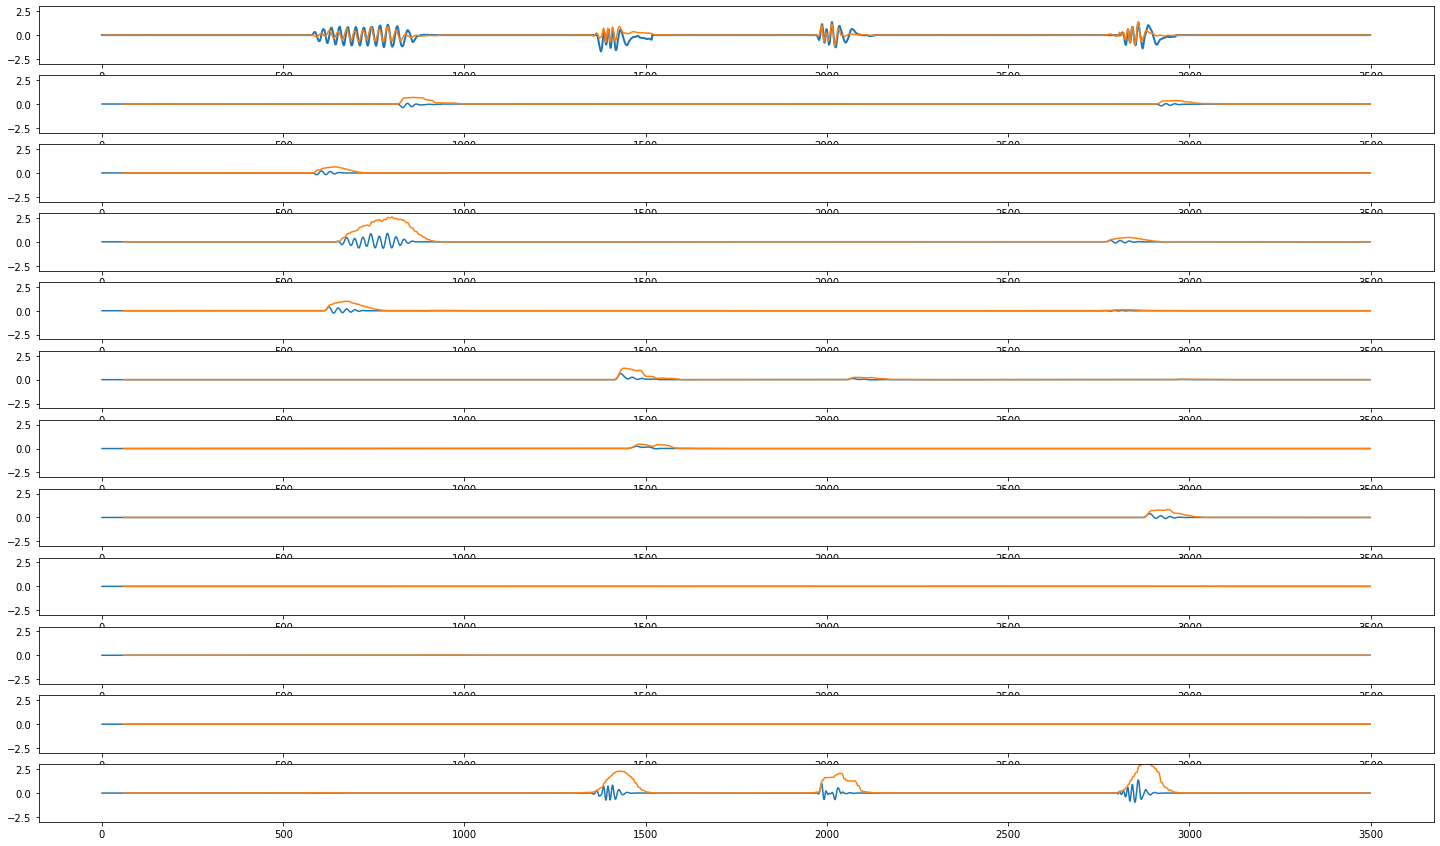

In [25]:
import matplotlib.gridspec as gridspec

Duration = 700*5
IdSt = 943000#np.random.randint(decomposition.shape[0]-Duration)


fig, ax = plt.subplots(facecolor='white',figsize=(25,15)) 

G = gridspec.GridSpec(12,1)

ax = plt.subplot(G[0])
ax.plot(tail_angle_detrend[IdSt:IdSt+Duration,-1],lw=2)
ax.plot(tail_angle_hat_[IdSt:IdSt+Duration,-1])
ax.set_ylim(-3,3)

for i in range(decomposition.shape[1]):
    ax = plt.subplot(G[i+1])
    tmp = decomposition[IdSt:IdSt+Duration,i]
    ax.plot(tmp)
    ts = pd.Series(tmp)
    # calculate a 60 day rolling mean and plot
    energy = ts.rolling(window=60).std()
    ax.plot(5*energy.values)
    ax.set_ylim(-3,3)
    #ax.set_xticks([])
plt.show()

# Using Head Restrained Optimized Dict

In [10]:
f = np.load('Dict_OptimizedHeadRestrained.npz')
Dict = f['Dict']
N_atoms = Dict.shape[2]
Wg = np.ones((1,N_atoms))


In [11]:
# Batch Dataset:
tail_angle_batch = batch_tail_angle(tail_angle_detrend[:,:7])

print(tail_angle_batch.shape)

T_trial = tail_angle_batch.shape[0]
N_Seg = tail_angle_batch.shape[1]
z = np.zeros((T_trial,N_atoms,1))

opt = cbpdnin.ConvBPDNInhib.Options({'Verbose': True, 'MaxMainIter': 200,
                                        'RelStopTol': 5e-3, 'AuxVarObj': False,'HighMemSolve': True})                                    
b = cbpdnin.ConvBPDNInhib(Dict[:,:,:],tail_angle_batch,lmbda =0.05, Wg=Wg,gamma=0.05,mu=0.05,Whn=60,win_args='box', opt=opt, dimK=1, dimN=1)
z = b.solve().squeeze()
tail_hat = b.reconstruct().squeeze()

# Unbatch Result
z_flat = np.zeros((z.shape[0]*z.shape[1],z.shape[2]))
for i in range(z.shape[2]):
    z_flat[:,i] = z[:,:,i].T.flatten()
z = np.copy(z_flat)
z = z[:tail_angle_detrend.shape[0],:]
tail_angle_hat_ = np.zeros((tail_hat.shape[0]*tail_hat.shape[2],tail_hat.shape[1]))
for i in range(tail_hat.shape[1]):
    tail_angle_hat_[:,i] = tail_hat[:,i,:].T.flatten()
tail_angle_hat_ = tail_angle_hat_[:tail_angle_detrend.shape[0],:]



(21000, 7, 61)
Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------
   0  2.97e+03  1.07e+03  1.34e+04  2.14e+04  3.12e+03  3.96e-01  4.48e+00  3.50e+00
   1  4.50e+03  6.72e+02  1.50e+04  5.30e+04  8.54e+03  4.64e-01  1.41e+00  3.50e+00
   2  6.14e+03  9.42e+02  1.70e+04  7.51e+04  1.19e+04  5.12e-01  2.91e-01  1.69e+00
   3  5.99e+03  9.78e+02  1.32e+04  7.39e+04  1.31e+04  3.63e-01  2.10e-01  1.88e+00
   4  5.81e+03  1.13e+03  1.13e+04  6.85e+04  1.38e+04  2.48e-01  1.58e-01  2.08e+00
   5  5.79e+03  1.21e+03  9.99e+03  6.68e+04  1.48e+04  1.82e-01  1.25e-01  2.08e+00
   6  5.70e+03  1.27e+03  9.36e+03  6.38e+04  1.56e+04  1.41e-01  1.00e-01  2.08e+00
   7  5.59e+03  1.30e+03  8.68e+03  6.10e+04  1.61e+04  1.14e-01  8.28e-02  2.08e+00
   8  5.45e+03  1.34e+03  8.21e+03  5.77e+04  1.64e+04  9.31e-02  7.09e-02  2.08e+00
   9  5.34e+03  1.36e+03  7.78e+03  5.51e+04  1.67

In [16]:
decomposition = np.zeros((z.shape[0],z.shape[1]))
for k in range(z.shape[1]):
    decomposition[:,k] = decomposition[:,k]+np.convolve(z[:,k],Dict[:,-1,k],'full')[:z.shape[0]]


regressor = np.zeros_like(z)
for k in range(z.shape[1]):
    ts = pd.Series(decomposition[:,k])
    # calculate a 60 day rolling mean and plot
    regressor[:,k] = ts.rolling(window=60).std()


[0 1 2 3 4 5 6 7 8 9]


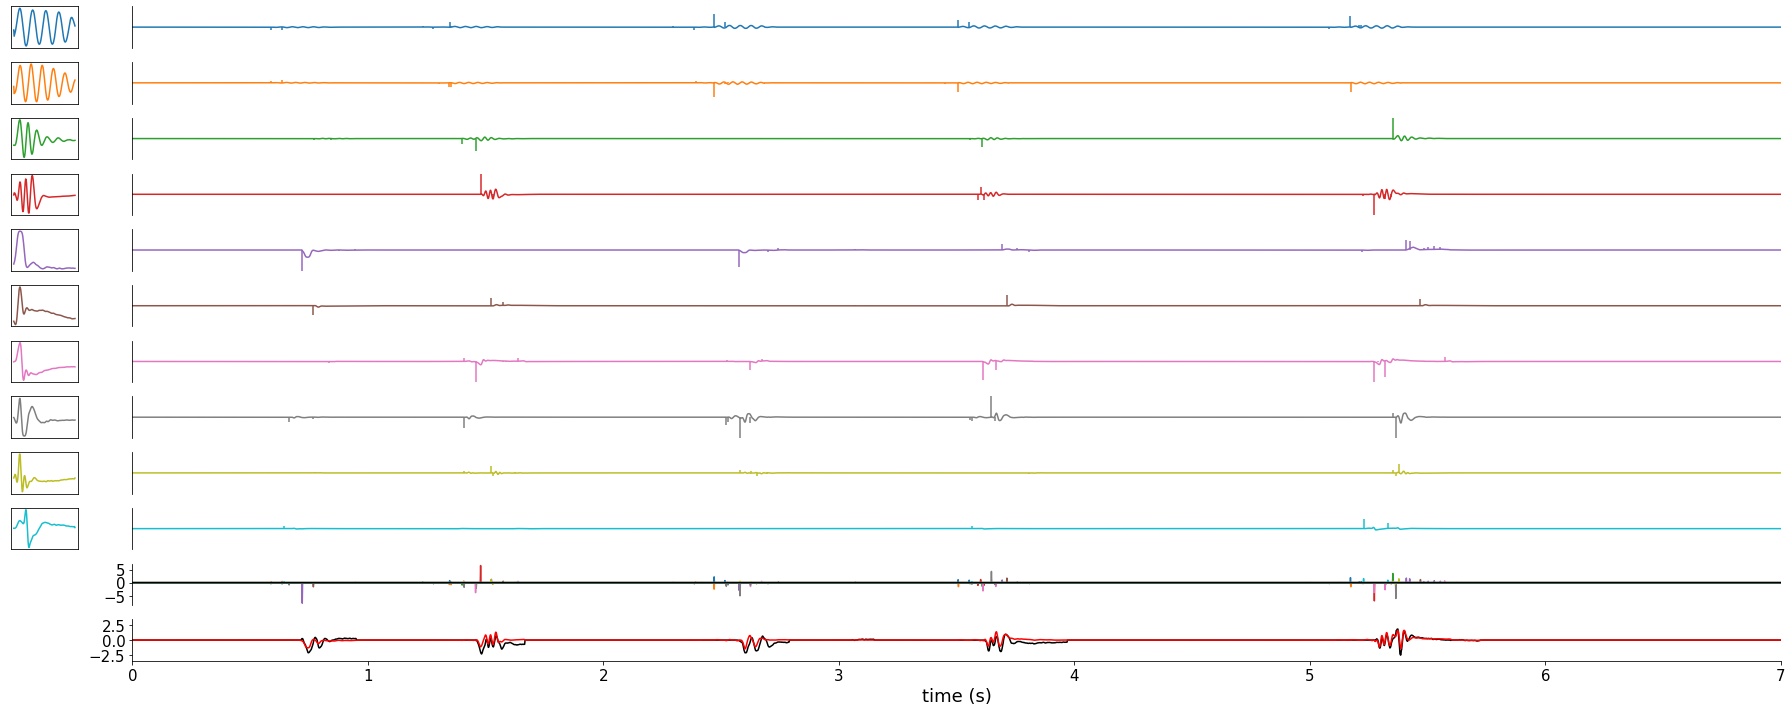

In [17]:
Duration = 700*7
IdSt = 212070
IdEd = IdSt+Duration

id_atom = np.arange(Dict.shape[-1])
print(id_atom)
N = len(id_atom)
cmap = plt.cm.tab10  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]

t = np.linspace(0,Duration/700,Duration)

fig, ax = plt.subplots(facecolor='white',figsize=(25,10),tight_layout=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(N+2,15)

ax = plt.subplot(G[-1:,1:])
ax.plot(t,tail_angle_detrend[IdSt:IdEd,-1],'k')
ax.plot(t,tail_angle_hat_[IdSt:IdSt+Duration,-1],'r')

ax.set_ylim(-3.5,3.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0,Duration/700)
ax.set_xlabel('time (s)',fontdict={'fontsize':18})
#ax.set_ylabel('tail angle \n (rad)',fontdict={'fontsize':18},rotation='horizontal')

ax = plt.subplot(G[-2,1:])
for i,i_code in enumerate(id_atom):
    ax.plot(t,z[IdSt:IdEd,i_code],color=cmaplist[i])
ax.plot(t,z[IdSt:IdEd,i_code]*0,color='k')
ax.set_xticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim(0,Duration/700)
#ax.set_ylabel('sparse code',fontdict={'fontsize':18},rotation='horizontal')

# ax.set_ylim(-3,3)
markerline = {}
stemline = {}
for i,i_code in enumerate(id_atom):
    ax = plt.subplot(G[i,1:])
    
    y = z[IdSt:IdEd,i_code]
    x = t
    x = x[np.abs(y)>0.1]
    y = y[np.abs(y)>0.1]
    markerline[i], stemline[i], baseline = ax.stem(x,y,use_line_collection=True)
    baseline.remove()
    markerline[i].remove()
    #plt.setp(markerline[i], color=cmaplist[i]) 
    plt.setp(stemline[i], color=cmaplist[i])

    ax.plot(t,decomposition[IdSt:IdEd,i_code],color=cmaplist[i])
    ax.set_ylim(-3.5,3.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlim(0,Duration/700)

    ax = plt.subplot(G[i,0])
    ax.plot(Dict[:,-1,i_code,],color=cmaplist[i])
    ax.set_xticks([])
    ax.set_yticks([])


#plt.savefig('SparseCoding_'+strain+'.png',dpi=300, bbox_inches = "tight")

plt.show()

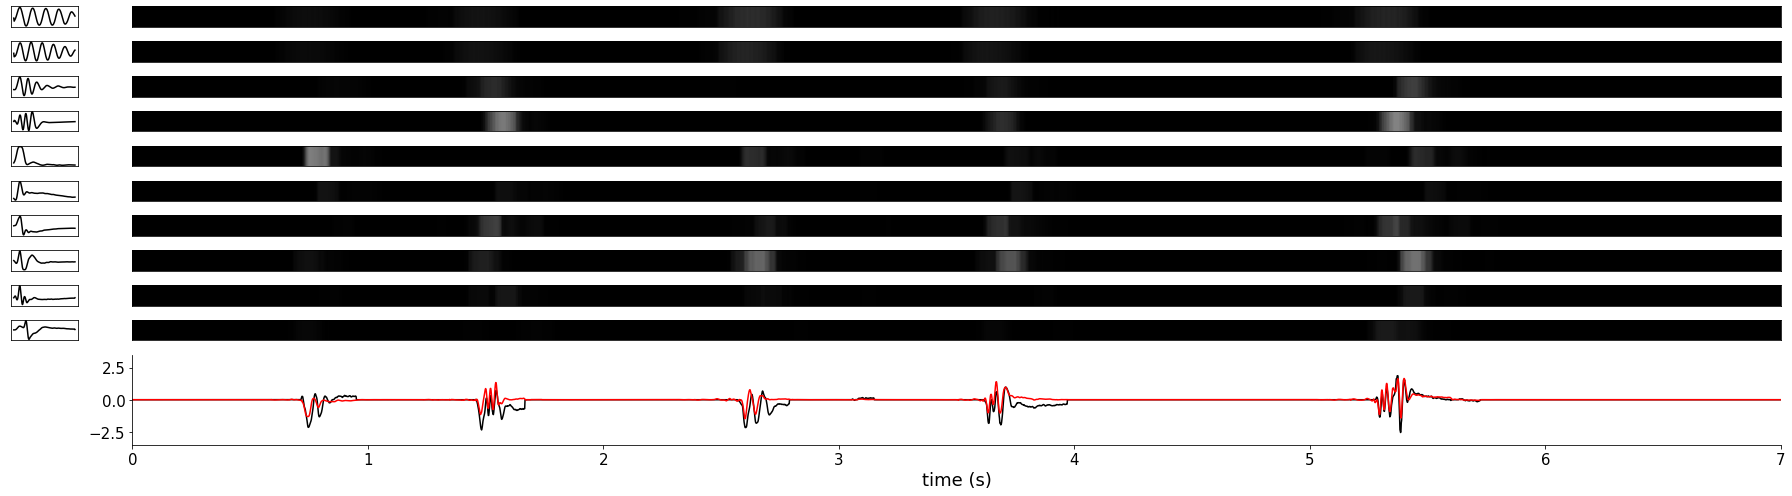

In [18]:
Duration = 700*7
IdSt = 212070
IdEd = IdSt+Duration

t = np.linspace(0,Duration/700,Duration)

fig, ax = plt.subplots(facecolor='white',figsize=(25,7),tight_layout=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(N+3,15)


ax = plt.subplot(G[10:,1:])
ax.plot(t,tail_angle_detrend[IdSt:IdEd,-1],'k')
ax.plot(t,tail_angle_hat_[IdSt:IdSt+Duration,-1],'r')

ax.set_ylim(-3.5,3.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0,Duration/700)
ax.set_xlabel('time (s)',fontdict={'fontsize':18})
#ax.set_ylabel('tail angle \n (rad)',fontdict={'fontsize':18},rotation='horizontal')

for i in range(Dict.shape[-1]):
    ax = plt.subplot(G[i,1:])
    ax.imshow(regressor[IdSt:IdEd,i:i+1].T,aspect='auto',cmap='gray',interpolation='none',vmin=0,vmax=1,extent=[0,t[-1],0,1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax = plt.subplot(G[i,0])
    ax.plot(Dict[:,-1,i,],color='k')
    ax.set_xticks([])
    ax.set_yticks([])
